# Determining the number of model replications

The netlogo model is stochastic, therefore two model runs with the same model settings will render different model outcomes. To be able to compare the model outcomes over different scenarios, it is thus important to take the average of multiple model runs. How many times the model must be run to get a representative outcome will be explored in this notebook.

First the model is loaded.

In [3]:
#Import the relevant packages from the EMA workbench
from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging)
from ema_workbench.connectors.netlogo import NetLogoModel
from ema_workbench import MultiprocessingEvaluator
from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS
from ema_workbench import (Constant, TimeSeriesOutcome, IntegerParameter, RealParameter, BooleanParameter, SequentialEvaluator, MultiprocessingEvaluator, ScalarOutcome, ema_logging, perform_experiments, ArrayOutcome, Policy)
from ema_workbench.connectors import netlogo
from ema_workbench.connectors.netlogo import NetLogoModel
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.evaluators import SOBOL
from ema_workbench import save_results

__all__ = ['NetLogoLink',
           'NetLogoException']

#Import other packages
import pyNetLogo
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [5]:
ema_logging.log_to_stderr(ema_logging.INFO)

#Define model outcomes
outcomes = [TimeSeriesOutcome('legal_products_end_user'),
            TimeSeriesOutcome('illegal_EU_products_end_user'),
            TimeSeriesOutcome('NOP_products_end_user')
           ]

#Define the NetLogo model
nl_model = NetLogoModel('NetLogo', wd = os.getcwd(), model_file="Netlogo_model/Crop_protection_products_NL_final.nlogo")
nl_model.run_length = int(396)
nl_model.replications = 1000
nl_model.uncertainties = [RealParameter('nr_of_PPPs_inspected_upon_visit_trader', 0, 50)]
nl_model.outcomes = outcomes
nl_model.constants = [Constant('progression_visualisation?', False),
                     Constant('fixed-seed?', False),
                     Constant('Nr_of_types_of_crops', 5),
                     Constant('Nr_of_types_of_diseases', 2),
                     Constant('Nr_of_end_users', 300),
                     Constant ('Nr_of_traders', 15),
                     Constant('inspect_end_users?', False),
                     Constant('inspect_end_user_only_traders?', False),
                     Constant('inspect_trader_to_trader_only_traders?', False),
                     Constant('Nr_of_inspectors', 0),
                     Constant('%_profiling_used', 0),
                     Constant('fixed_trust_period', 36),  
                     Constant('nr_of_PPPs_inspected_upon_visit_end_user', 0),
                     Constant('inspection_chance_NL_border', 0.05),
                     Constant ('%_always_comply_end_users', 60),
                     Constant('%_always_comply_traders', 90),
                     Constant('%_traders_end_user_only', 70),
                     Constant('%_coverage_of_disease_crop_combinations_legal_products', 70),
                     Constant('minimum_profit', 1000),
                     Constant('%_avg_chance_to_get_disease', 5 ),
                     Constant('fine-to-profit_ratio', 0.3)               
                 ] 

With the Netlogo model, a 1000 replications are performed over one predefined scenario. The model must include at least one uncertainty for the latin hypercube sampling to work, so the nr_of_PPPs_inspected_upon_visit has been randomly drawn for the predefined scenario.

In [4]:
#Perform the model runs
with MultiprocessingEvaluator(nl_model, n_processes = 8) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=1, uncertainty_sampling=LHS)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Inspect the outcomes.

In [6]:
experiments

,nr_of_PPPs_inspected_upon_visit_trader,scenario,policy,model
0,23.636756,0,None,NetLogo


In [7]:
outcomes

{'legal_products_end_user': array([[[   0.,    7.,   29., ..., 6645., 6664., 6679.],
         [   0.,   12.,   31., ..., 6677., 6693., 6708.],
         [   0.,   14.,   32., ..., 6360., 6376., 6389.],
         ...,
         [   0.,   17.,   29., ..., 6354., 6368., 6386.],
         [   0.,   18.,   39., ..., 6652., 6665., 6684.],
         [   0.,   15.,   30., ..., 6400., 6416., 6440.]]]),
 'illegal_EU_products_end_user': array([[[  0.,   0.,   0., ...,  29.,  29.,  29.],
         [  0.,   0.,   0., ...,  12.,  12.,  12.],
         [  0.,   0.,   0., ..., 148., 149., 149.],
         ...,
         [  0.,   0.,   0., ..., 178., 179., 180.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,  12.,  12.,  12.]]]),
 'NOP_products_end_user': array([[[  0.,   0.,   0., ...,  38.,  40.,  40.],
         [  0.,   0.,   0., ...,   2.,   2.,   2.],
         [  0.,   0.,   0., ..., 296., 296., 297.],
         ...,
         [  0.,   0.,   0., ..., 220., 222., 223.],


In [11]:
#Store the data in pickles.
a_file = open("Results/data.pkl", "wb")
pickle.dump(outcomes, a_file)
a_file.close()
experiments.to_pickle("Results/experiments.pkl")
opened_results = pd.read_pickle("Results/data.pkl")

Next, the outcome file with the results from the 1000 model replications will be cut into slices of varying length, to portray the effect of varying the number of model runs on the average outcome values.

In [5]:
#Create a function that creates a plot of the varying number of model runs.
def create_model_replication_plots(title, type_of_products):
    
    #Get the desired model outcomes
    opened_results = pd.read_pickle("Results/data.pkl")
    intended_results = opened_results.get(type_of_products)
    
    #Create the data slices of the model outcomes
    averaged_1 = np.squeeze(intended_results[0][0:1])
    averaged_10 = np.average(intended_results[0][0:10], axis=0)
    averaged_25 = np.average(intended_results[0][0:25], axis=0)
    averaged_50 = np.average(intended_results[0][0:50], axis=0)
    averaged_100 = np.average(intended_results[0][0:100], axis=0)
    averaged_500 = np.average(intended_results[0][0:500], axis=0)
    averaged_1000 = np.average(intended_results[0], axis=0)
    
    #Create the plots
    plt.xlabel('ticks')
    plt.ylabel(type_of_products)
    plt.title(title)
    plt.plot(averaged_1, label = '1 run')
    plt.plot(averaged_10, label = '10 runs')
    plt.plot(averaged_25, label = '25 runs')
    plt.plot(averaged_50, label = '50 runs')
    plt.plot(averaged_100, label = '100 runs')
    plt.plot(averaged_500, label = '500 runs')
    plt.plot(averaged_1000, label = '1000 runs')
    plt.legend()
    plt.show()


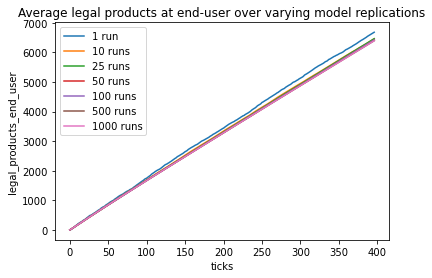

In [6]:
#Create a plot of the legal products that reach the end-user over a varying number of model runs
create_model_replication_plots('Average legal products at end-user over varying model replications', 'legal_products_end_user')

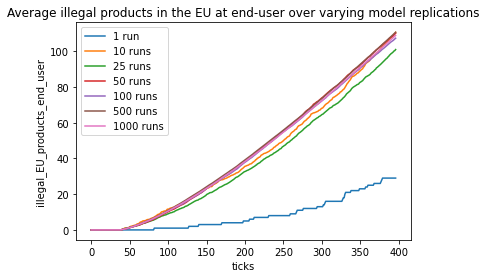

In [7]:
#Create a plot of the illegal products in the EU that reach the end-user over a varying number of model runs
create_model_replication_plots('Average illegal products in the EU at end-user over varying model replications', 'illegal_EU_products_end_user')

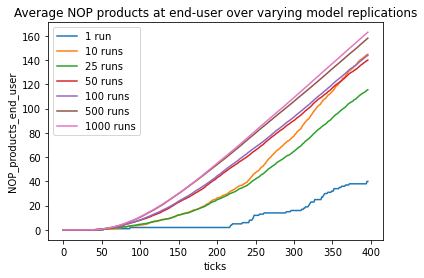

In [8]:
#Create a plot of the NOP products that reach the end-user over a varying number of model runs
create_model_replication_plots('Average NOP products at end-user over varying model replications', 'NOP_products_end_user')

It is also interesting to look at the mean and standard deviation of the model outcomes over time. These are plotted below. 

In [9]:
#Create a function that shows the mean and standard deviation of a specified number of replications.
def create_std_plots(type_of_products, numreps):
    
    #Retrieve the desired data
    opened_results = pd.read_pickle("Results/data.pkl")
    intended_results = opened_results.get(type_of_products)
    
    #Plot the mean and standard deviation of the desired data range
    title = "Average and standard deviation for " + str(numreps) + " repetitions."
    plt.xlabel('ticks')
    plt.ylabel(type_of_products)
    plt.title(title)
    average= np.average(intended_results[0][0:numreps], axis=0)
    st_dev = np.std(intended_results[0][0:numreps], axis=0)
    x = range(len(st_dev))
    plt.errorbar(x = x, y = average, yerr = st_dev, ecolor = "green", linestyle='None', marker='^')
    plt.show()

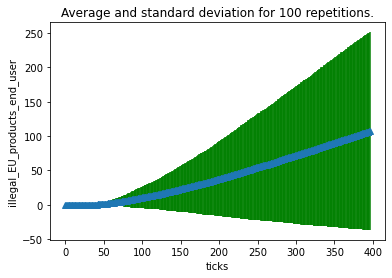

In [10]:
#Create a mean and standard deviation plot of 100 model replications for the illegal products in the EU 
create_std_plots('illegal_EU_products_end_user', 100)

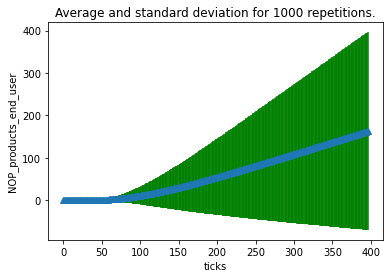

In [53]:
#Create a mean and standard deviation plot of 1000 model replications for the NOP products
create_std_plots('NOP_products_end_user', 1000)

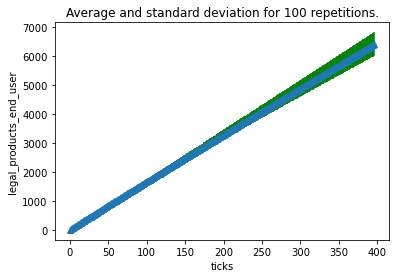

In [12]:
#Create a mean and standard deviation plot of 100 model replications for the legal products
create_std_plots('legal_products_end_user', 100)

To get a different perspective on the variability of the model, plots can be made of the individual model runs. 

Text(0.5, 1.0, '1000 individual runs - legal products')

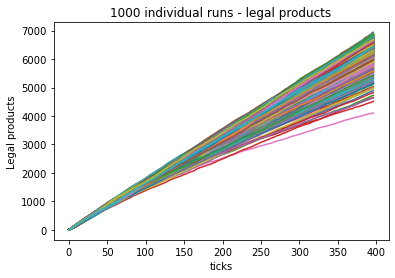

In [54]:
#Create a plot of all 1000 model runs for the legal products arriving at the end-user

#Retrieve the desired results
opened_results = pd.read_pickle("Results/data.pkl")
legal_EU_products = opened_results.get('legal_products_end_user').squeeze()

#Plot the individual model runs
for r in range(len(legal_EU_products)):
        plt.plot(legal_EU_products[r])
    
plt.xlabel('ticks')
plt.ylabel("Legal products")
plt.title("1000 individual runs - legal products")

Text(0.5, 1.0, '1000 individual runs - illegal products')

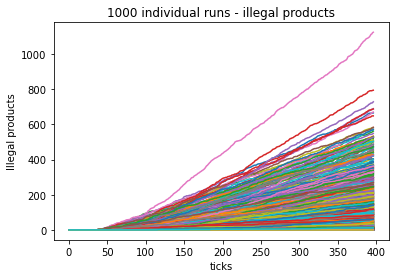

In [55]:
#Create a plot of all 1000 model runs for the illegal products in the EU arriving at the end-user

#Retrieve the desired results
opened_results = pd.read_pickle("Results/data.pkl")
illegal_EU_products = opened_results.get('illegal_EU_products_end_user').squeeze()

#Plot the individual model runs
for r in range(len(illegal_EU_products)):
        plt.plot(illegal_EU_products[r])
    
plt.xlabel('ticks')
plt.ylabel("Illegal products")
plt.title("1000 individual runs - illegal products")

Text(0.5, 1.0, '1000 individual runs - NOP products EU')

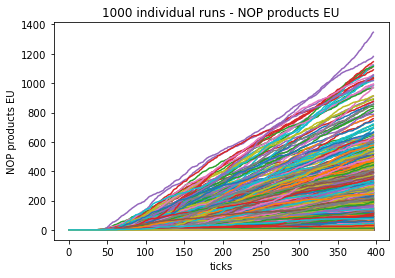

In [51]:
#Create a plot of all 1000 model runs for the NOP products arriving at the end-user

#Retrieve the desired results
opened_results = pd.read_pickle("Results/data.pkl")
NOP_products = opened_results.get('NOP_products_end_user').squeeze()

#Plot the individual model runs
for r in range(len(NOP_products)):
        plt.plot(NOP_products[r])
    
plt.xlabel('ticks')
plt.ylabel("NOP products EU")
plt.title("1000 individual runs - NOP products EU")